In [ ]:
!pip install --quiet transformers==4.5.0
!pip install --quiet pytorch-lightning==1.2.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 62.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.7/830.7 KB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 KB 51.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1


In [ ]:
import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

In [ ]:
pl.seed_everything(42)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#''' Filepath : AP '''
train_filepath = "/content/drive/MyDrive/datasets/CNNDAILYMAIL/cnn_dailymail/train.csv"
test_filepath = "/content/drive/MyDrive/datasets/CNNDAILYMAIL/cnn_dailymail/test.csv"
validation_filepath = "/content/drive/MyDrive/datasets/CNNDAILYMAIL/cnn_dailymail/validation.csv"
# train_df, test_df = train_test_split(df, test_size=0.4)
# train_df.shape, test_df.shape

Mounted at /content/drive


In [ ]:
df = pd.read_csv(train_filepath)
test_df = pd.read_csv(test_filepath)
validation_df = pd.read_csv(validation_filepath)
df = df[['article', 'highlights']]
test_df = test_df[['article', 'highlights']]
validation_df = validation_df[['article', 'highlights']]
df.head()
df.columns = ['summary', 'text']
test_df.columns = ['summary', 'text']
df = df.dropna()
test_df = test_df.dropna()
validation_df = validation_df.dropna()
df.head()

,summary,text
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


# For Training on Train

In [ ]:
print("Shape Validation:",validation_df.shape)
print("Shape train:",df.shape)
print("Shape test:",test_df.shape)

Shape Validation: (13368, 2)
Shape train: (287113, 2)
Shape test: (11490, 2)


In [ ]:
# train_df, test_df = train_test_split(df, test_size=0.1)
# train_df.shape, test_df.shape

# For Testing

In [ ]:
train_df, test_df = train_test_split(test_df, test_size=0.9)
train_df.shape, test_df.shape

((1149, 2), (10341, 2))

In [ ]:
df.columns = ['summary', 'text']
df = df.dropna()
df.head()

,summary,text
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
class NewsSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        text = data_row['text']

        text_encoding = tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        summary_encoding = tokenizer(
            data_row['summary'],
            max_length=self.summary_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100 # to make sure we have correct labels for T5 text generation

        return dict(
            text=text,
            summary=data_row['summary'],
            text_input_ids=text_encoding['input_ids'].flatten(),
            text_attention_mask=text_encoding['attention_mask'].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding['attention_mask'].flatten()
        )

In [ ]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        text_max_token_len: int = 512,
        summary_max_token_len: int = 128
    ):
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def setup(self, stage=None):
        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

In [ ]:
MODEL_NAME = 't5-base'

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():
    text_token_count = len(tokenizer.encode(row['text']))
    text_token_counts.append(text_token_count)

    summary_token_count = len(tokenizer.encode(row['summary']))
    summary_token_counts.append(summary_token_count)   

Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


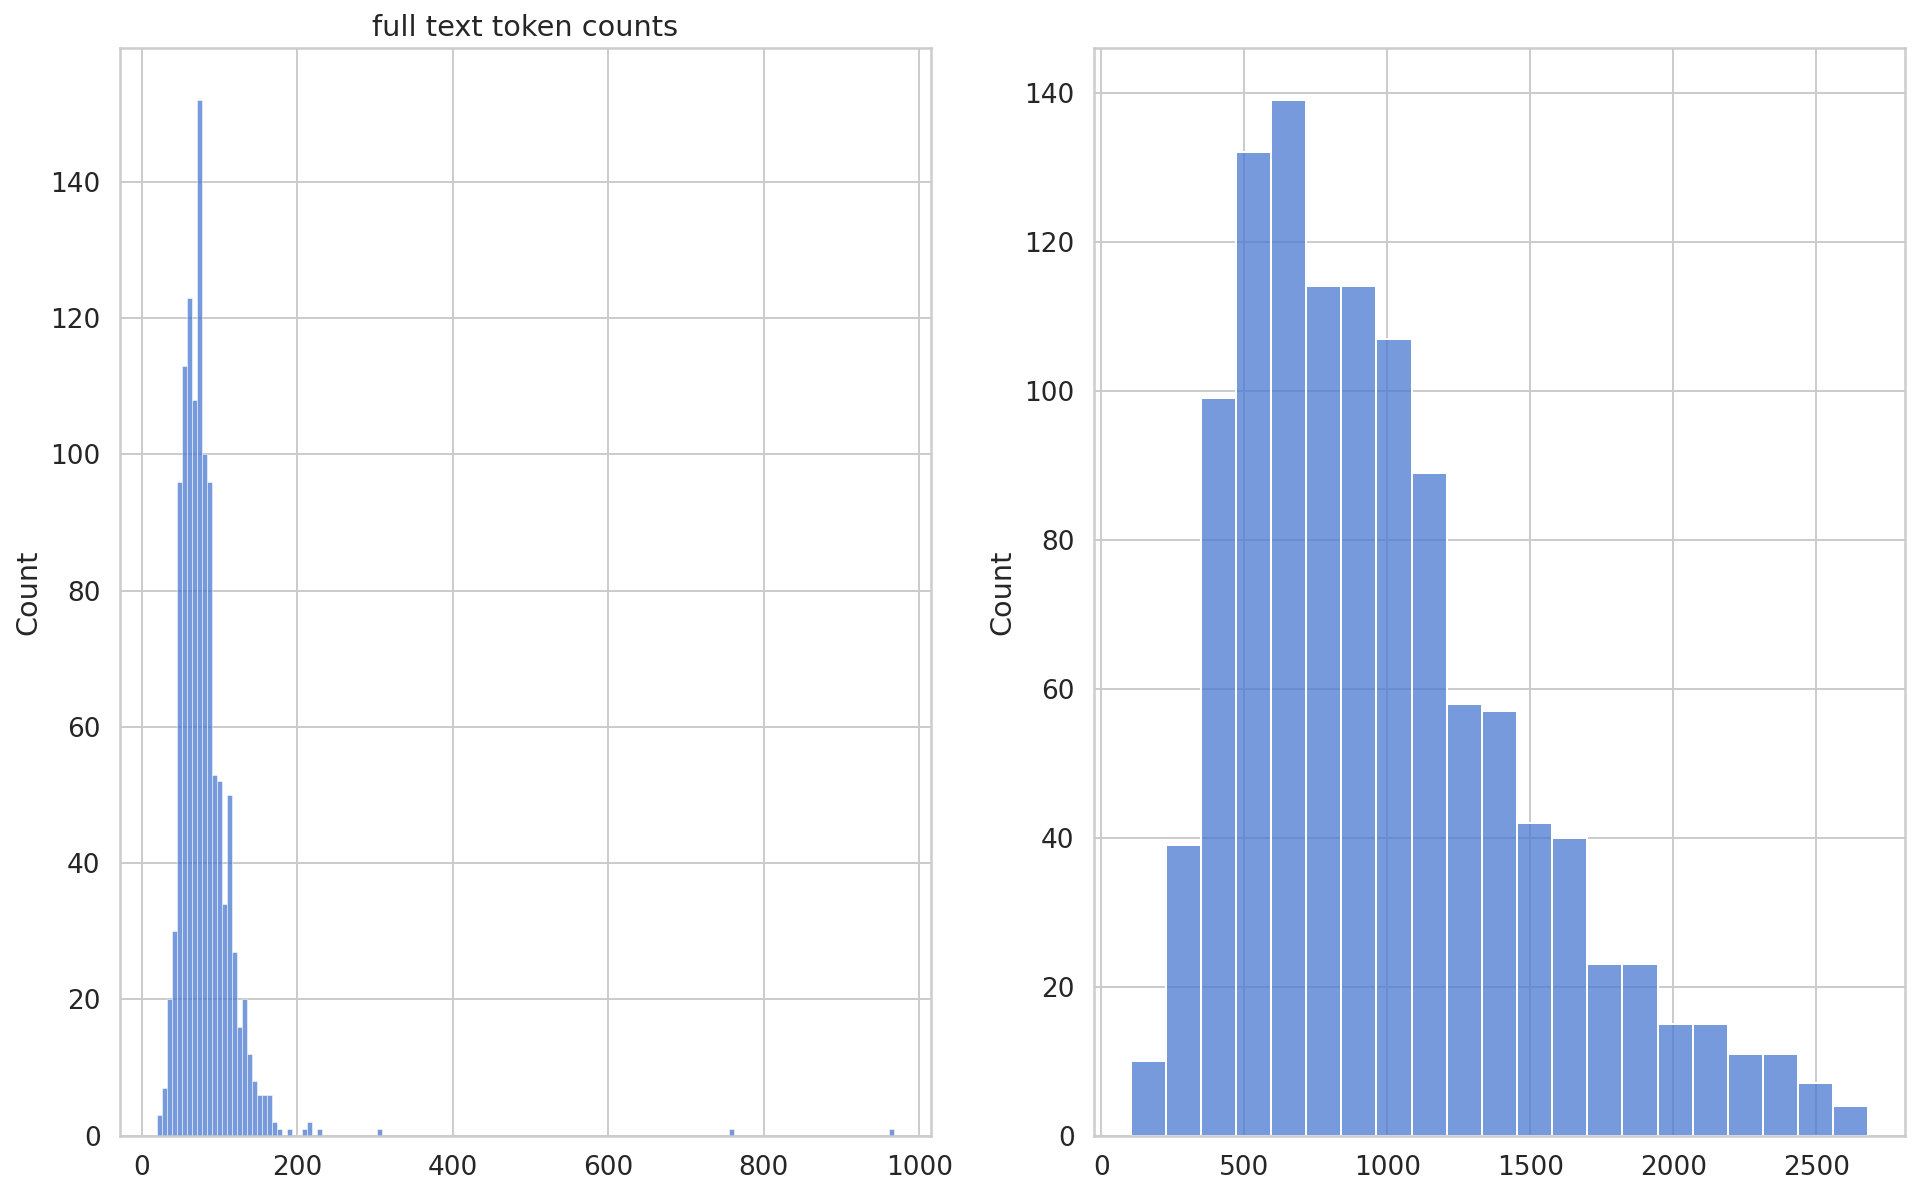

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(text_token_counts, ax=ax1)
ax1.set_title('full text token counts')
sns.histplot(summary_token_counts, ax=ax2)

In [ ]:
N_EPOCHS = 3
BATCH_SIZE = 6

data_module = NewsSummaryDataModule(train_df, test_df, tokenizer)

In [ ]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
    
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [ ]:
model = NewsSummaryModel()

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name='news-summary')

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, data_module)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
trained_model.freeze()

In [ ]:
def summarizeText(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)

In [ ]:
import pickle

In [ ]:
# filename = open('text_summarization_model.pkl', 'wb')
# pickle.dump(trained_model.model, filename)

# path = F"/content/drive/MyDrive/Models/{filename}"
# pickle.dump(trained_model.model, path)

Mounted at /content/drive


# Saving and testing the model

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/Models/text_summarization_model.pkl', 'rb'))

In [ ]:
def summarizeText(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)

In [ ]:
summarizeText(""" Nepal Bankers’ Association, an organisation of managers of commercial banks, has decided to reduce interest rates on deposits beginning from coming Sunday.

A recent meeting of the association decided to lower the rates within the limits set by the Nepal Rastra Bank, informs the association’s president Sunil KC.

So far, the banks have been giving interest at a maximum rate of 12.13 per cent on individual deposits and of 10.13 per cent on institutional interests. Now, in effect from next week, they will go down.

Whereas the rates of interest on deposits will go down immediately, it will take three months to reduce rates of interest on loans, according to the association.

 """)

'The Nepal Bankers’ Association has decided to reduce interest rates on deposits starting from coming Sunday. This comes after a recent meeting of the association decided to lower the rates within the limits set by the Nepal Rastra Bank. So far, banks have been giving interest at a maximum rate of 12.13% on individual deposits and 10.13% on institutional interests.'

In [ ]:
values = validation_df['article'].iloc[:10].apply(lambda x : summarizeText(str(x)))

In [ ]:
values

0    Sally Forrest, an actress-dancer who graced th...
1    Politics teacher Wang Lian, 35, has created 10...
2    Iftekhar Murtaza, 30, was sentenced to death o...
3    Prince Harry, who is a Vice Patron of the Rugb...
4    Triple M Radio producer Nick Slater received o...
5    Stoke City's manager of the year Mark Hughes h...
6    Antiquities Minister Mamdouh el-Damaty said th...
7    Dr Ashleigh Witt, a medical registrar in Melbo...
8    Ronda Rousey beat Cat Zingano in the fastest-e...
9    Celtic defender Virgil van Dijk was sent off f...
Name: article, dtype: object

In [ ]:
""" Nepal Bankers’ Association, an organisation of managers of commercial banks, has decided to reduce interest rates on deposits beginning from coming Sunday.

A recent meeting of the association decided to lower the rates within the limits set by the Nepal Rastra Bank, informs the association’s president Sunil KC.

So far, the banks have been giving interest at a maximum rate of 12.13 per cent on individual deposits and of 10.13 per cent on institutional interests. Now, in effect from next week, they will go down.

Whereas the rates of interest on deposits will go down immediately, it will take three months to reduce rates of interest on loans, according to the association.

 """